In [1]:
# Import libraries
import os, sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set project root and change working directory
project_root = Path.cwd().parent.parent
os.chdir(project_root)
print(f"📁 Working directory: {os.getcwd()}")

# Add src directory to Python path
sys.path.insert(0, str(project_root / "src"))

from tiingo import TiingoClient
from core.config import Config
from market import ESGManager, ESGFactorBuilder, PriceManager, RiskFreeRateManager
from universe import SP500Universe

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")

📁 Working directory: /Users/frank/Projects/QuantX/quantx-data-builder
✅ Libraries imported successfully
✅ Libraries imported successfully


In [2]:
# Initialize components
config = Config(str(project_root / "config/settings.yaml"))
universe = SP500Universe()
esg_mgr = ESGManager(universe=universe)

# Initialize ESGFactorBuilder (requires both esg_manager and universe)
esg_builder = ESGFactorBuilder(esg_manager=esg_mgr, universe=universe)

print("✅ Components initialized successfully")
print(f"   - Universe: SP500Universe")
print(f"   - ESG Manager: {type(esg_mgr).__name__}")
print(f"   - ESG Factor Builder: {type(esg_builder).__name__}")

✅ Components initialized successfully
   - Universe: SP500Universe
   - ESG Manager: ESGManager
   - ESG Factor Builder: ESGFactorBuilder


# ESG Factor Construction with ESGFactorBuilder

This notebook demonstrates how to use the **ESGFactorBuilder** class to construct ESG factors for the S&P 500 universe. We'll explore three different formation methods:

1. **ESG Score Formation** - Uses the composite ESG score with cross-sectional rankings
2. **Pillar-Weighted Formation** - Creates custom-weighted scores from E, S, G pillars
3. **Momentum Formation** - Captures ESG improvement over time

## 1. Load Historical S&P 500 Members

First, we'll identify all companies that were part of the S&P 500 during our analysis period.

In [3]:
# Define analysis period
start_date = '2014-01-01'
end_date = '2024-12-31'

print(f"📅 Analysis Period: {start_date} to {end_date}")
print(f"\n🔍 Loading S&P 500 historical members...")

# Get all tickers that were in S&P 500 during the period
sp500_members = universe.get_all_historical_members(
    period_start=start_date,
    period_end=end_date,
)

print(f"✅ Found {len(sp500_members)} unique tickers with S&P 500 membership")
print(f"\nSample tickers: {', '.join(sorted(sp500_members)[:10])}")

# Store for later use
tickers = sorted(sp500_members)

📅 Analysis Period: 2014-01-01 to 2024-12-31

🔍 Loading S&P 500 historical members...
✅ Found 748 unique tickers with S&P 500 membership

Sample tickers: A, AABA, AAL, AAP, AAPL, ABBV, ABC, ABMD, ABNB, ABT


## 2. Build ESG Factors - Method 1: ESG Score Formation

The default method uses the composite ESG score and creates cross-sectional rankings within each time period.

In [4]:
# Build ESG factors using ESG Score method
print("=" * 80)
print("METHOD 1: ESG Score Formation")
print("=" * 80)

factors_esg_score = esg_builder.build_factors_for_universe(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    formation_method='esg_score'
)

print(f"\n✅ ESG Score factors constructed")
print(f"   Shape: {factors_esg_score.shape}")
print(f"   Tickers: {factors_esg_score['ticker'].nunique()}")
print(f"   Date range: {factors_esg_score['date'].min()} to {factors_esg_score['date'].max()}")
print(f"\n📊 Factor columns created:")
factor_cols = [col for col in factors_esg_score.columns if any(x in col for x in ['_zscore', '_pctrank', '_decile'])]
for col in factor_cols:
    print(f"   - {col}")

# Show sample data
print(f"\n📋 Sample data (latest month):")
latest_date = factors_esg_score['date'].max()
sample = factors_esg_score[factors_esg_score['date'] == latest_date].sort_values('ticker').head(5)[
    ['ticker', 'esg_score', 'esg_score_zscore', 'esg_score_pctrank', 'esg_score_decile']
]
print(sample.to_string(index=False))

METHOD 1: ESG Score Formation


No ESG data found for AABA on us
No ESG data found for AAL on us
No ESG data found for AAL on us
No ESG data found for ABC on us
No ESG data found for ABMD on us
No ESG data found for ABC on us
No ESG data found for ABMD on us
No ESG data found for ACGL on us
No ESG data found for ACN on us
No ESG data found for ACGL on us
No ESG data found for ACN on us
No ESG data found for ADS on us
No ESG data found for ADS on us
No ESG data found for AET on us
No ESG data found for AET on us
No ESG data found for AGN on us
No ESG data found for AGN on us
No ESG data found for AIV on us
No ESG data found for AIV on us
No ESG data found for ALLE on us
No ESG data found for ALTR on us
No ESG data found for ALXN on us
No ESG data found for ALLE on us
No ESG data found for ALTR on us
No ESG data found for ALXN on us
No ESG data found for AMCR on us
No ESG data found for AMCR on us
No ESG data found for AME on us
No ESG data found for AME on us
No ESG data found for AMT on us
No ESG data found for AMTM 


✅ ESG Score factors constructed
   Shape: (54049, 20)
   Tickers: 456
   Date range: 2014-01-31 00:00:00 to 2024-12-31 00:00:00

📊 Factor columns created:
   - esg_score_pctrank
   - esg_score_zscore
   - esg_score_decile

📋 Sample data (latest month):
ticker  esg_score  esg_score_zscore  esg_score_pctrank esg_score_decile
     A  80.012846          1.076484          87.919463                9
  AAPL  74.589033          0.674671          73.378076                8
  ABBV  71.162644          0.420834          63.087248                7
  ABNB  34.561657         -2.290678           2.013423                1
   ABT  83.491422          1.334187          93.736018               10


## 3. Build ESG Factors - Method 2: Pillar-Weighted Formation

Create custom-weighted composite scores from Environmental, Social, and Governance pillars.

In [5]:
# Build ESG factors using Pillar-Weighted method
print("\n" + "=" * 80)
print("METHOD 2: Pillar-Weighted Formation")
print("=" * 80)

# Custom weights: emphasize Environmental factors
# Note: Use single-letter keys 'E', 'S', 'G' as required by ESGFactorBuilder
pillar_weights = {
    'E': 0.60,  # Environmental
    'S': 0.20,  # Social
    'G': 0.20   # Governance
}

factors_pillar_weighted = esg_builder.build_factors_for_universe(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    formation_method='pillar_weighted',
    pillar_weights=pillar_weights
)

print(f"\n✅ Pillar-weighted factors constructed")
print(f"   Weights: E={pillar_weights['E']:.0%}, S={pillar_weights['S']:.0%}, G={pillar_weights['G']:.0%}")
print(f"   Shape: {factors_pillar_weighted.shape}")
print(f"   Tickers: {factors_pillar_weighted['ticker'].nunique()}")

# Show sample data
print(f"\n📋 Sample data (latest month):")
sample = factors_pillar_weighted[factors_pillar_weighted['date'] == latest_date].sort_values('ticker').head(5)[
    ['ticker', 'pillar_weighted_score', 'pillar_weighted_score_zscore', 'pillar_weighted_score_pctrank']
]
print(sample.to_string(index=False))

No ESG data found for AABA on us
No ESG data found for AAL on us
No ESG data found for AAL on us



METHOD 2: Pillar-Weighted Formation


No ESG data found for ABC on us
No ESG data found for ABMD on us
No ESG data found for ABMD on us
No ESG data found for ACGL on us
No ESG data found for ACN on us
No ESG data found for ACGL on us
No ESG data found for ACN on us
No ESG data found for ADS on us
No ESG data found for ADS on us
No ESG data found for AET on us
No ESG data found for AET on us
No ESG data found for AGN on us
No ESG data found for AGN on us
No ESG data found for AIV on us
No ESG data found for AIV on us
No ESG data found for ALLE on us
No ESG data found for ALTR on us
No ESG data found for ALXN on us
No ESG data found for ALLE on us
No ESG data found for ALTR on us
No ESG data found for ALXN on us
No ESG data found for AMCR on us
No ESG data found for AMCR on us
No ESG data found for AME on us
No ESG data found for AME on us
No ESG data found for AMT on us
No ESG data found for AMTM on us
No ESG data found for AMT on us
No ESG data found for AMTM on us
No ESG data found for ANDV on us
No ESG data found for AND


✅ Pillar-weighted factors constructed
   Weights: E=60%, S=20%, G=20%
   Shape: (54049, 21)
   Tickers: 456

📋 Sample data (latest month):
ticker  pillar_weighted_score  pillar_weighted_score_zscore  pillar_weighted_score_pctrank
     A              77.974000                      0.980288                      84.340045
  AAPL              71.306687                      0.549890                      67.114094
  ABBV              66.417921                      0.234303                      53.467562
  ABNB              27.405697                     -2.284074                       2.013423
   ABT              81.073929                      1.180399                      90.827740


## 4. Build ESG Factors - Method 3: Momentum Formation

Capture ESG improvement over time using momentum windows.

In [6]:
# Build ESG factors using Momentum method
print("\n" + "=" * 80)
print("METHOD 3: Momentum Formation")
print("=" * 80)

factors_momentum = esg_builder.build_factors_for_universe(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    formation_method='momentum',
    momentum_windows=[6, 12]
)

print(f"\n✅ Momentum factors constructed")
print(f"   Windows: 6-month, 12-month")
print(f"   Shape: {factors_momentum.shape}")
print(f"   Tickers: {factors_momentum['ticker'].nunique()}")

# Show sample data
print(f"\n📋 Sample data (latest month):")
sample = factors_momentum[factors_momentum['date'] == latest_date].sort_values('ticker').head(5)[
    ['ticker', 'esg_score', 'esg_score_momentum_6m', 'esg_score_momentum_12m', 'esg_score_momentum_12m_zscore']
]
print(sample.to_string(index=False))

# Show top improvers
print(f"\n🚀 Top 10 ESG Improvers (12-month momentum):")
improvers = factors_momentum[factors_momentum['date'] == latest_date].dropna(
    subset=['esg_score_momentum_12m']
).nlargest(10, 'esg_score_momentum_12m')[
    ['ticker', 'esg_score', 'esg_score_momentum_12m']
]
print(improvers.to_string(index=False))

No ESG data found for AABA on us
No ESG data found for AAL on us
No ESG data found for AAL on us



METHOD 3: Momentum Formation


No ESG data found for ABC on us
No ESG data found for ABMD on us
No ESG data found for ABMD on us
No ESG data found for ACGL on us
No ESG data found for ACN on us
No ESG data found for ACGL on us
No ESG data found for ACN on us
No ESG data found for ADS on us
No ESG data found for ADS on us
No ESG data found for AET on us
No ESG data found for AET on us
No ESG data found for AGN on us
No ESG data found for AGN on us
No ESG data found for AIV on us
No ESG data found for AIV on us
No ESG data found for ALLE on us
No ESG data found for ALTR on us
No ESG data found for ALXN on us
No ESG data found for ALLE on us
No ESG data found for ALTR on us
No ESG data found for ALXN on us
No ESG data found for AMCR on us
No ESG data found for AMCR on us
No ESG data found for AME on us
No ESG data found for AME on us
No ESG data found for AMT on us
No ESG data found for AMTM on us
No ESG data found for AMT on us
No ESG data found for AMTM on us
No ESG data found for ANDV on us
No ESG data found for AND


✅ Momentum factors constructed
   Windows: 6-month, 12-month
   Shape: (54049, 22)
   Tickers: 456

📋 Sample data (latest month):
ticker  esg_score  esg_score_momentum_6m  esg_score_momentum_12m  esg_score_momentum_12m_zscore
     A  80.012846                    0.0               -2.321693                      -0.149071
  AAPL  74.589033                    0.0               -3.548738                      -0.312719
  ABBV  71.162644                    0.0               -2.714493                      -0.201457
  ABNB  34.561657                    0.0               -9.874361                      -1.156354
   ABT  83.491422                    0.0                0.662337                       0.248903

🚀 Top 10 ESG Improvers (12-month momentum):
ticker  esg_score  esg_score_momentum_12m
    DG  60.097433               32.195643
   THC  56.144264               28.961965
  ILMN  83.545434               26.561624
  BLDR  43.780923               25.993213
  VRSK  76.749983               24.035

## 5. Visualize ESG Score Distribution Over Time

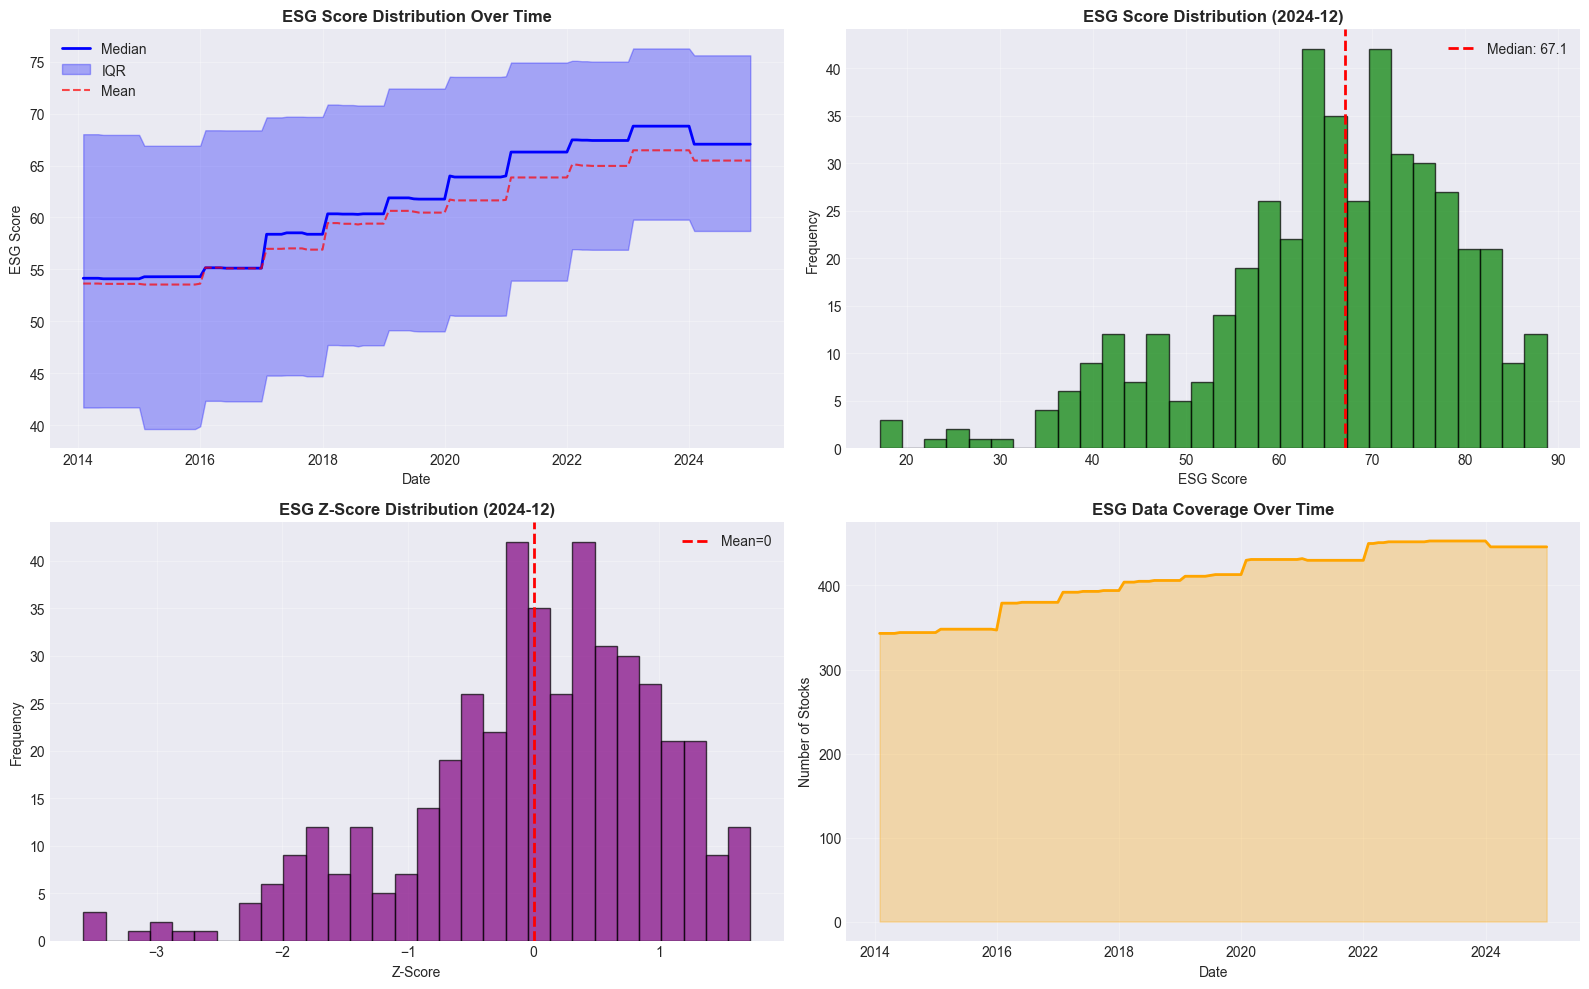

✅ ESG score distributions visualized


In [7]:
# Visualize ESG score distribution over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. ESG Score time series (median and quartiles)
monthly_stats = factors_esg_score.groupby('date')['esg_score'].agg([
    'mean', 'median', 
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
])

axes[0, 0].plot(monthly_stats.index, monthly_stats['median'], 
                label='Median', linewidth=2, color='blue')
axes[0, 0].fill_between(monthly_stats.index, monthly_stats['q25'], monthly_stats['q75'], 
                         alpha=0.3, label='IQR', color='blue')
axes[0, 0].plot(monthly_stats.index, monthly_stats['mean'], 
                label='Mean', linewidth=1.5, linestyle='--', color='red', alpha=0.7)
axes[0, 0].set_title('ESG Score Distribution Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('ESG Score')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ESG Score histogram (latest month)
latest_scores = factors_esg_score[factors_esg_score['date'] == latest_date]['esg_score'].dropna()
axes[0, 1].hist(latest_scores, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].axvline(latest_scores.median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {latest_scores.median():.1f}')
axes[0, 1].set_title(f'ESG Score Distribution ({latest_date.strftime("%Y-%m")})', 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('ESG Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Cross-sectional Z-scores (should be ~N(0,1))
latest_zscores = factors_esg_score[factors_esg_score['date'] == latest_date]['esg_score_zscore'].dropna()
axes[1, 0].hist(latest_zscores, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean=0')
axes[1, 0].set_title(f'ESG Z-Score Distribution ({latest_date.strftime("%Y-%m")})', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Z-Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Number of stocks with ESG data over time
coverage = factors_esg_score.groupby('date')['ticker'].nunique()
axes[1, 1].plot(coverage.index, coverage.values, linewidth=2, color='orange')
axes[1, 1].fill_between(coverage.index, 0, coverage.values, alpha=0.3, color='orange')
axes[1, 1].set_title('ESG Data Coverage Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Number of Stocks')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ ESG score distributions visualized")

## 6. Visualize Factor Rankings and Deciles

/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/175990264.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_scores = latest_df.groupby('esg_score_decile')['esg_score'].agg(['mean', 'min', 'max'])
/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/175990264.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_ts = factors_esg_score.groupby(['date', 'esg_score_decile'])['esg_score_zscore'].median().unstack()


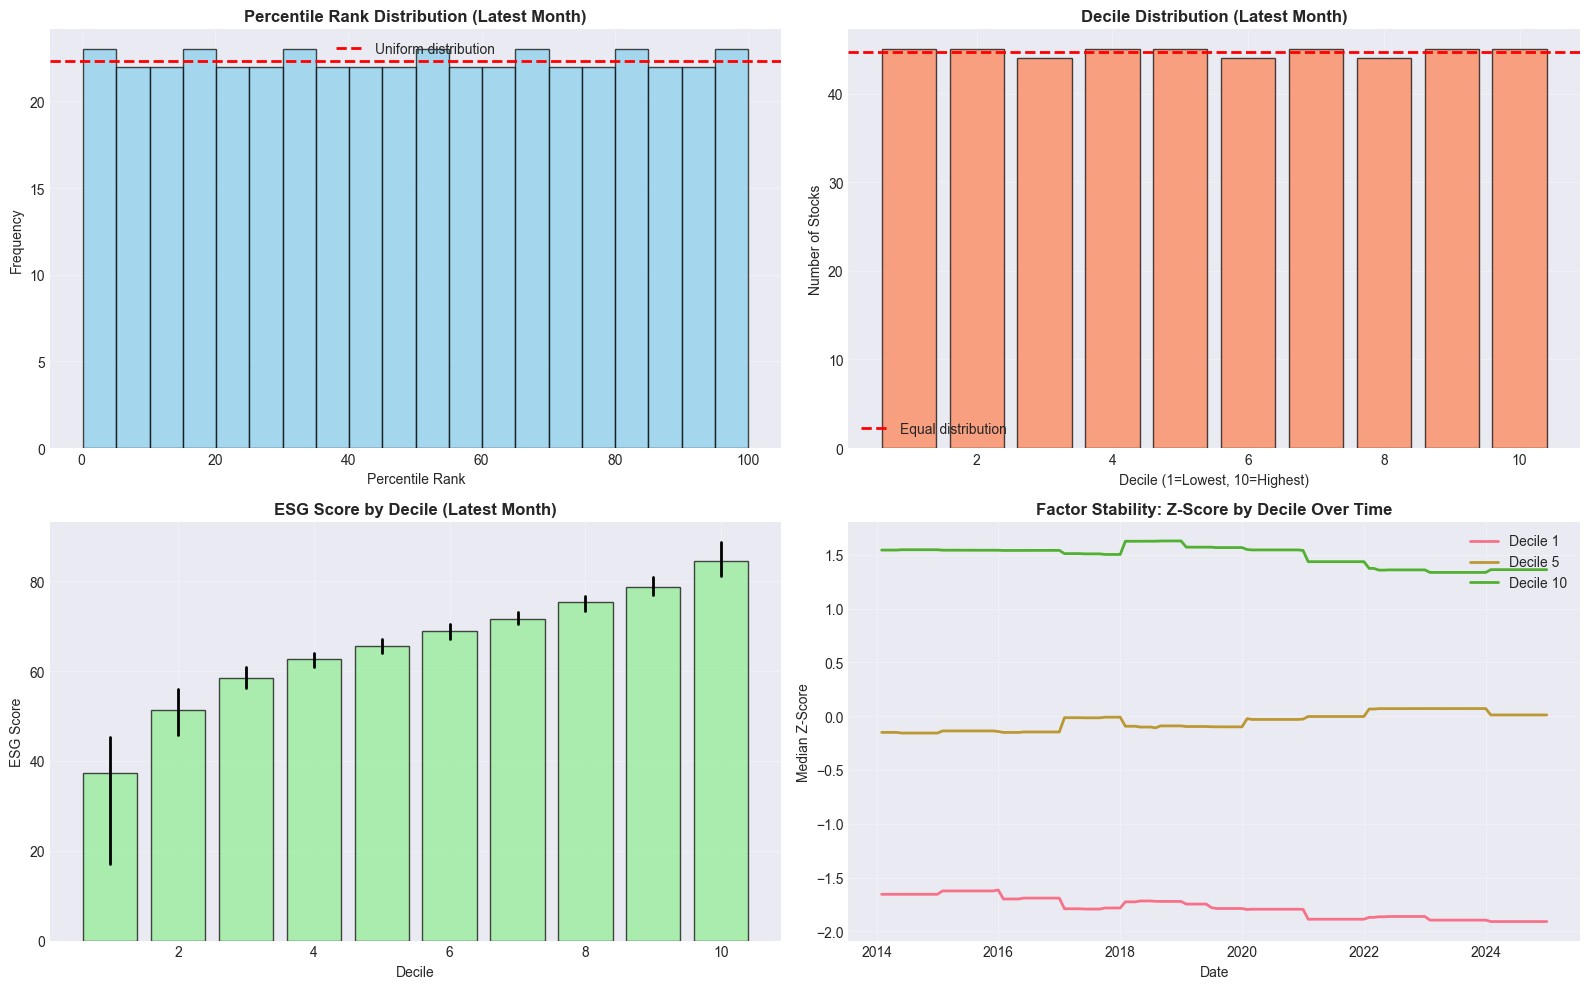

✅ Factor rankings visualized


In [8]:
# Visualize factor rankings and deciles
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Percentile rank distribution (should be uniform)
latest_pctrank = factors_esg_score[factors_esg_score['date'] == latest_date]['esg_score_pctrank'].dropna()
axes[0, 0].hist(latest_pctrank, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axhline(len(latest_pctrank)/20, color='red', linestyle='--', 
                   linewidth=2, label='Uniform distribution')
axes[0, 0].set_title('Percentile Rank Distribution (Latest Month)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Percentile Rank')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Decile distribution (should be ~equal)
latest_deciles = factors_esg_score[factors_esg_score['date'] == latest_date]['esg_score_decile'].dropna()
decile_counts = latest_deciles.value_counts().sort_index()
axes[0, 1].bar(decile_counts.index, decile_counts.values, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axhline(len(latest_deciles)/10, color='red', linestyle='--', 
                   linewidth=2, label='Equal distribution')
axes[0, 1].set_title('Decile Distribution (Latest Month)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Decile (1=Lowest, 10=Highest)')
axes[0, 1].set_ylabel('Number of Stocks')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. ESG Score by Decile (latest month)
latest_df = factors_esg_score[factors_esg_score['date'] == latest_date].copy()
decile_scores = latest_df.groupby('esg_score_decile')['esg_score'].agg(['mean', 'min', 'max'])
axes[1, 0].bar(decile_scores.index, decile_scores['mean'], 
               edgecolor='black', alpha=0.7, color='lightgreen')
for i, row in decile_scores.iterrows():
    axes[1, 0].plot([i, i], [row['min'], row['max']], 'k-', linewidth=2)
axes[1, 0].set_title('ESG Score by Decile (Latest Month)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Decile')
axes[1, 0].set_ylabel('ESG Score')
axes[1, 0].grid(True, alpha=0.3)

# 4. Factor stability over time (median Z-score by decile)
decile_ts = factors_esg_score.groupby(['date', 'esg_score_decile'])['esg_score_zscore'].median().unstack()
for decile in [1, 5, 10]:
    if decile in decile_ts.columns:
        axes[1, 1].plot(decile_ts.index, decile_ts[decile], 
                       label=f'Decile {decile}', linewidth=2)
axes[1, 1].set_title('Factor Stability: Z-Score by Decile Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Median Z-Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Factor rankings visualized")

/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/2583998550.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  improvers = factors_momentum.groupby('date').apply(
/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/2583998550.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decliners = factors_momentum.groupby('date').apply(


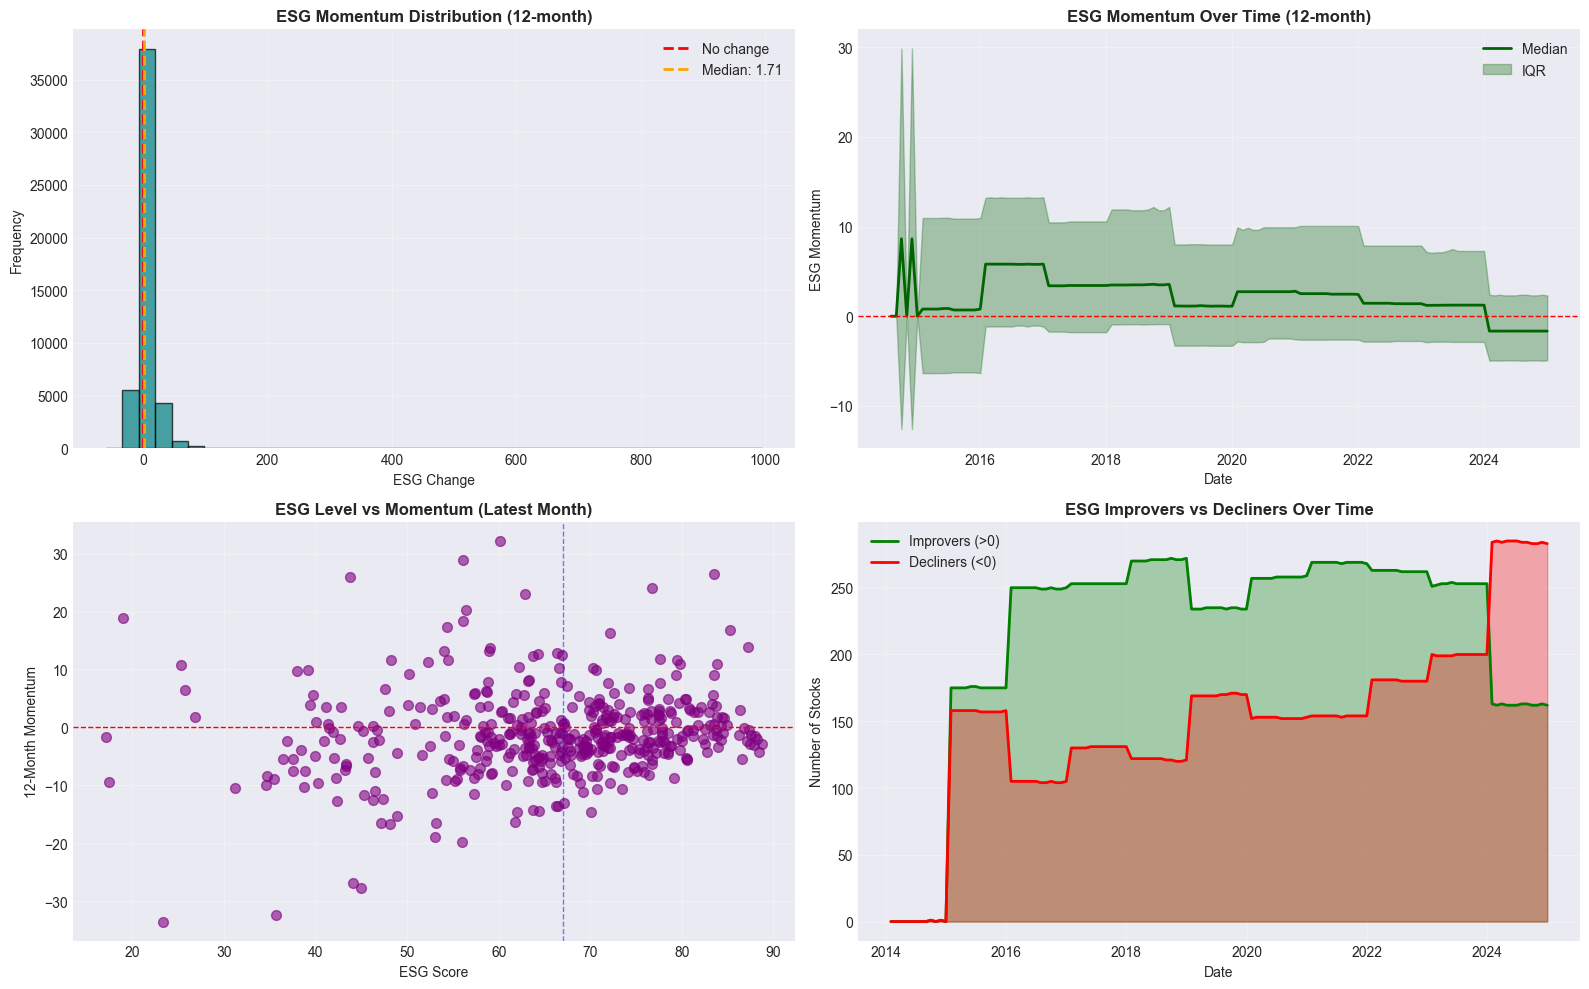

✅ ESG momentum visualized


In [9]:
# Visualize ESG momentum factors
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Momentum distribution (12-month)
momentum_12m = factors_momentum['esg_score_momentum_12m'].dropna()
axes[0, 0].hist(momentum_12m, bins=40, edgecolor='black', alpha=0.7, color='teal')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
axes[0, 0].axvline(momentum_12m.median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {momentum_12m.median():.2f}')
axes[0, 0].set_title('ESG Momentum Distribution (12-month)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('ESG Change')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Momentum over time (median and spread)
momentum_stats = factors_momentum.groupby('date')['esg_score_momentum_12m'].agg([
    'median',
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
])
axes[0, 1].plot(momentum_stats.index, momentum_stats['median'], 
                linewidth=2, color='darkgreen', label='Median')
axes[0, 1].fill_between(momentum_stats.index, momentum_stats['q25'], momentum_stats['q75'], 
                         alpha=0.3, color='darkgreen', label='IQR')
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_title('ESG Momentum Over Time (12-month)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('ESG Momentum')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter: ESG Level vs Momentum (latest month)
latest_momentum = factors_momentum[factors_momentum['date'] == latest_date].dropna(
    subset=['esg_score', 'esg_score_momentum_12m']
)
axes[1, 0].scatter(latest_momentum['esg_score'], latest_momentum['esg_score_momentum_12m'], 
                   alpha=0.6, s=50, color='purple')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 0].axvline(latest_momentum['esg_score'].median(), color='blue', 
                   linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].set_title('ESG Level vs Momentum (Latest Month)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('ESG Score')
axes[1, 0].set_ylabel('12-Month Momentum')
axes[1, 0].grid(True, alpha=0.3)

# 4. Top improvers vs decliners count over time
improvers = factors_momentum.groupby('date').apply(
    lambda x: (x['esg_score_momentum_12m'] > 0).sum()
)
decliners = factors_momentum.groupby('date').apply(
    lambda x: (x['esg_score_momentum_12m'] < 0).sum()
)
axes[1, 1].plot(improvers.index, improvers.values, 
                linewidth=2, color='green', label='Improvers (>0)')
axes[1, 1].plot(decliners.index, decliners.values, 
                linewidth=2, color='red', label='Decliners (<0)')
axes[1, 1].fill_between(improvers.index, 0, improvers.values, alpha=0.3, color='green')
axes[1, 1].fill_between(decliners.index, 0, decliners.values, alpha=0.3, color='red')
axes[1, 1].set_title('ESG Improvers vs Decliners Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Number of Stocks')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ ESG momentum visualized")

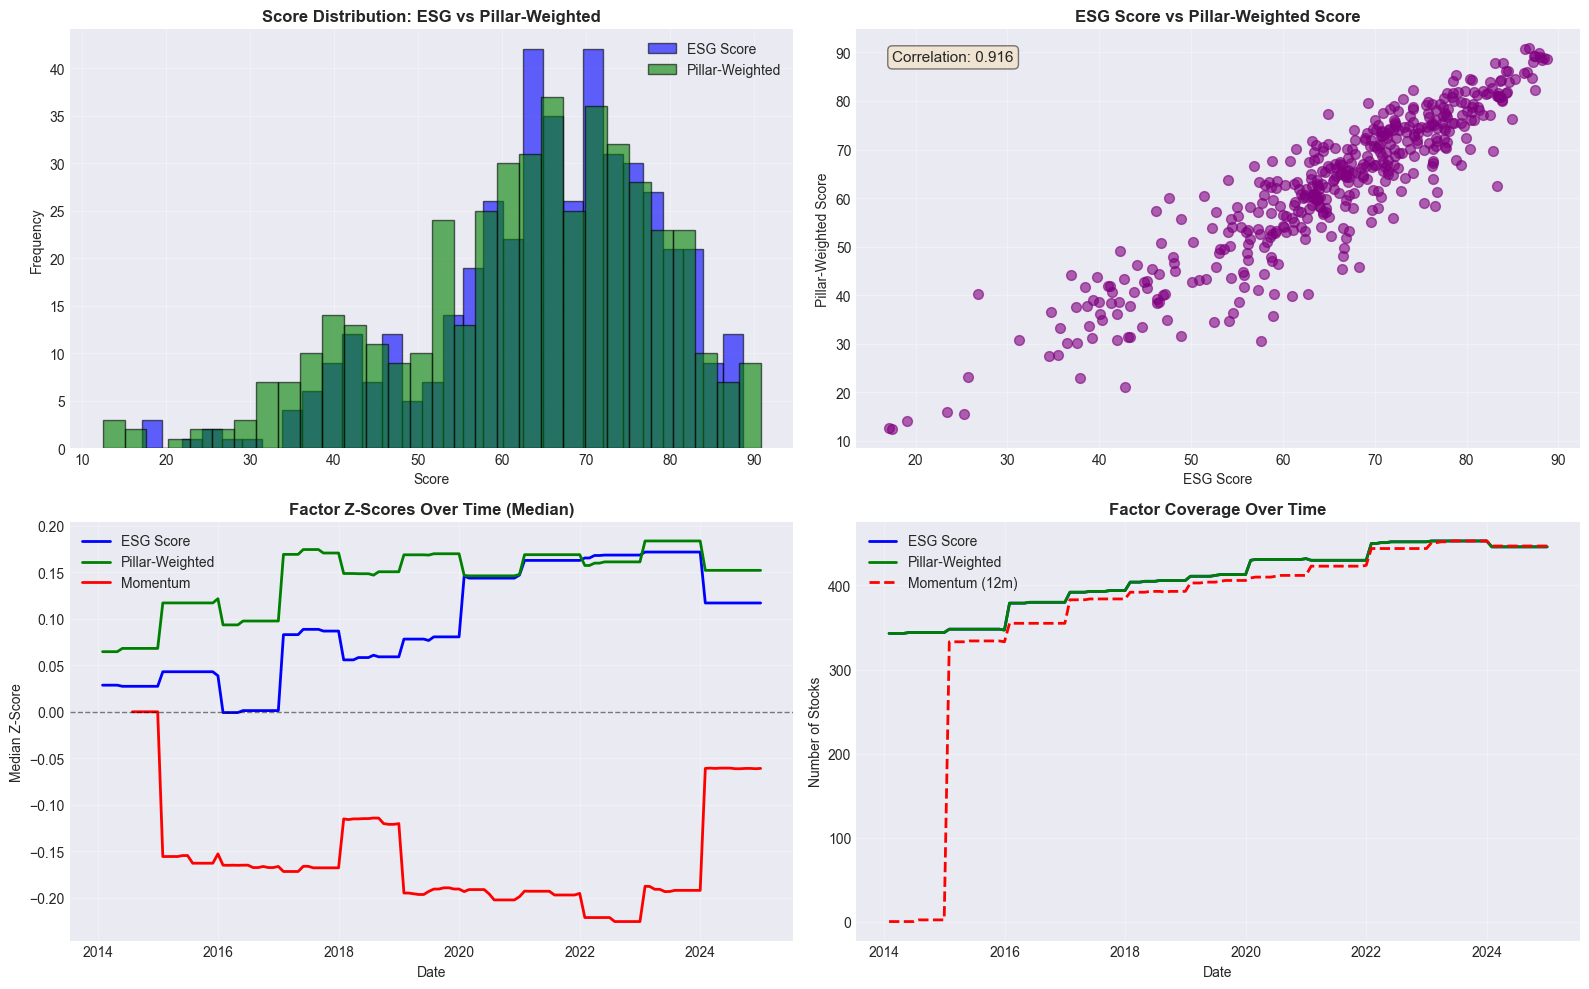

✅ Formation methods compared


In [10]:
# Compare the three formation methods
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Score distribution comparison (latest month)
latest_esg = factors_esg_score[factors_esg_score['date'] == latest_date]['esg_score'].dropna()
latest_pillar = factors_pillar_weighted[factors_pillar_weighted['date'] == latest_date]['pillar_weighted_score'].dropna()

axes[0, 0].hist(latest_esg, bins=30, alpha=0.6, label='ESG Score', color='blue', edgecolor='black')
axes[0, 0].hist(latest_pillar, bins=30, alpha=0.6, label='Pillar-Weighted', color='green', edgecolor='black')
axes[0, 0].set_title('Score Distribution: ESG vs Pillar-Weighted', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Correlation between methods (latest month)
merged_latest = factors_esg_score[factors_esg_score['date'] == latest_date][['ticker', 'esg_score']].merge(
    factors_pillar_weighted[factors_pillar_weighted['date'] == latest_date][['ticker', 'pillar_weighted_score']],
    on='ticker'
)
if len(merged_latest) > 0:
    axes[0, 1].scatter(merged_latest['esg_score'], merged_latest['pillar_weighted_score'], 
                       alpha=0.6, s=50, color='purple')
    # Add correlation coefficient
    corr = merged_latest['esg_score'].corr(merged_latest['pillar_weighted_score'])
    axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=axes[0, 1].transAxes, fontsize=11, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[0, 1].set_title('ESG Score vs Pillar-Weighted Score', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('ESG Score')
axes[0, 1].set_ylabel('Pillar-Weighted Score')
axes[0, 1].grid(True, alpha=0.3)

# 3. Z-score comparison over time (median)
esg_zscore = factors_esg_score.groupby('date')['esg_score_zscore'].median()
pillar_zscore = factors_pillar_weighted.groupby('date')['pillar_weighted_score_zscore'].median()
momentum_zscore = factors_momentum.groupby('date')['esg_score_momentum_12m_zscore'].median()

axes[1, 0].plot(esg_zscore.index, esg_zscore.values, 
                linewidth=2, label='ESG Score', color='blue')
axes[1, 0].plot(pillar_zscore.index, pillar_zscore.values, 
                linewidth=2, label='Pillar-Weighted', color='green')
axes[1, 0].plot(momentum_zscore.index, momentum_zscore.values, 
                linewidth=2, label='Momentum', color='red')
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].set_title('Factor Z-Scores Over Time (Median)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Median Z-Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Factor coverage over time
esg_coverage = factors_esg_score.groupby('date')['ticker'].nunique()
pillar_coverage = factors_pillar_weighted.groupby('date')['ticker'].nunique()
momentum_coverage = factors_momentum.groupby('date')['esg_score_momentum_12m'].count()

axes[1, 1].plot(esg_coverage.index, esg_coverage.values, 
                linewidth=2, label='ESG Score', color='blue')
axes[1, 1].plot(pillar_coverage.index, pillar_coverage.values, 
                linewidth=2, label='Pillar-Weighted', color='green')
axes[1, 1].plot(momentum_coverage.index, momentum_coverage.values, 
                linewidth=2, label='Momentum (12m)', color='red', linestyle='--')
axes[1, 1].set_title('Factor Coverage Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Number of Stocks')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Formation methods compared")

## 7. Analyze Pillar Contributions

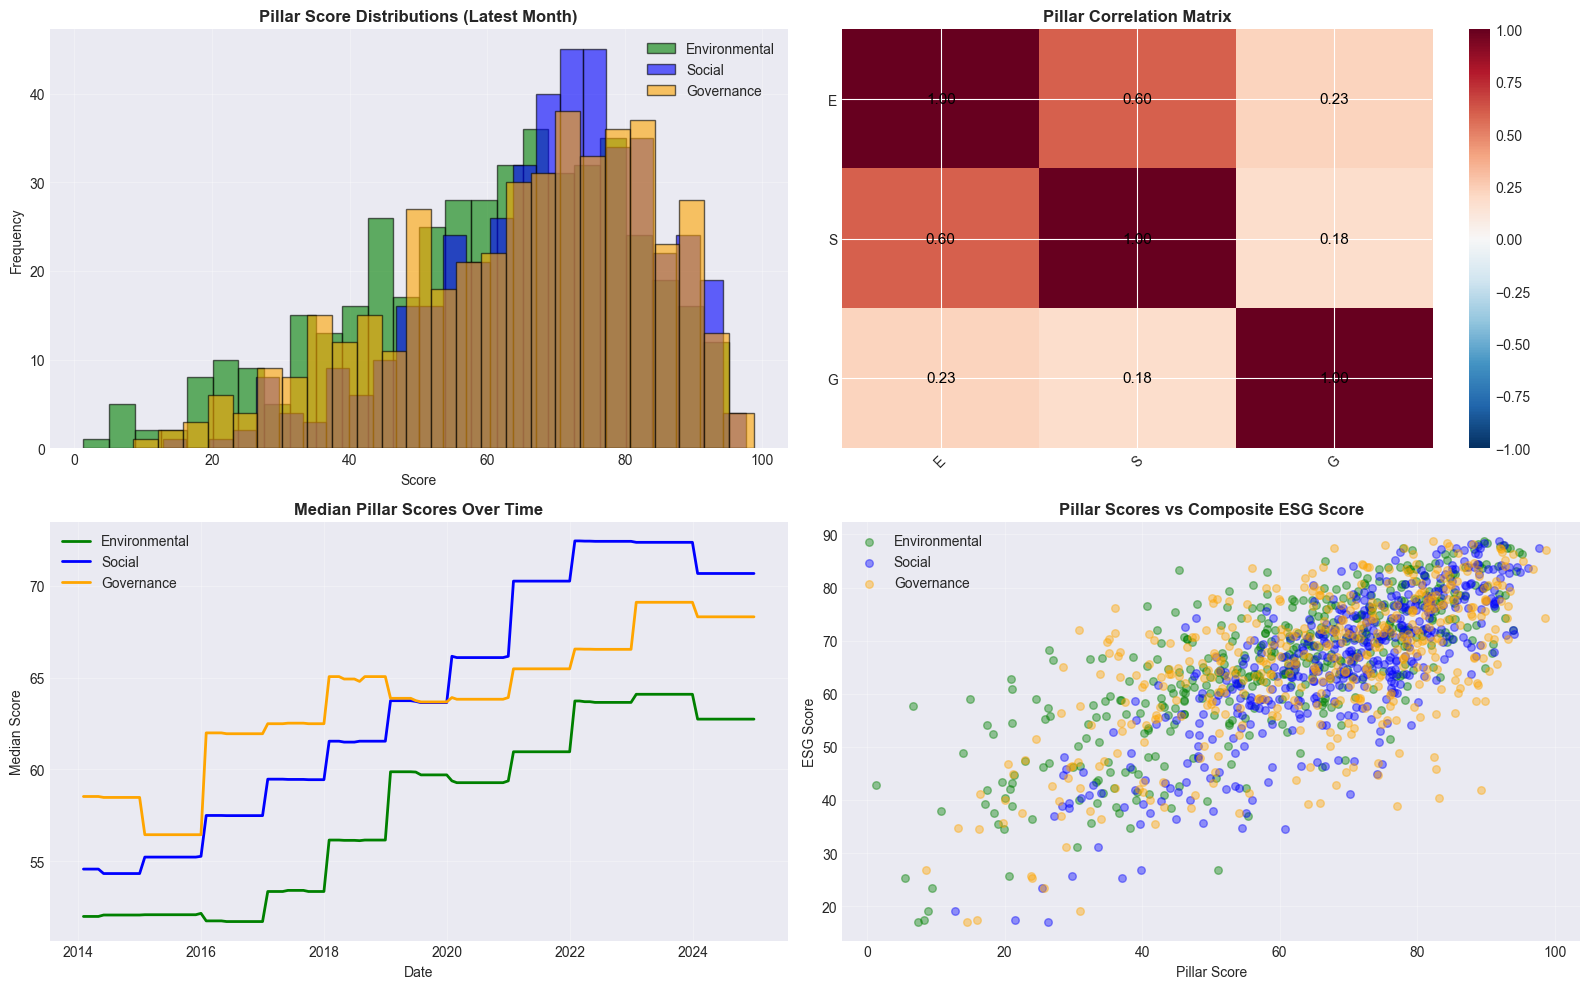

✅ Pillar contributions analyzed


In [11]:
# Analyze individual pillar contributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

latest_full = factors_esg_score[factors_esg_score['date'] == latest_date].copy()

# 1. Pillar scores distribution (latest month)
if 'environmental_pillar_score' in latest_full.columns:
    pillar_data = latest_full[['environmental_pillar_score', 'social_pillar_score', 
                                'governance_pillar_score']].dropna()
    
    axes[0, 0].hist(pillar_data['environmental_pillar_score'], bins=25, alpha=0.6, 
                    label='Environmental', color='green', edgecolor='black')
    axes[0, 0].hist(pillar_data['social_pillar_score'], bins=25, alpha=0.6, 
                    label='Social', color='blue', edgecolor='black')
    axes[0, 0].hist(pillar_data['governance_pillar_score'], bins=25, alpha=0.6, 
                    label='Governance', color='orange', edgecolor='black')
    axes[0, 0].set_title('Pillar Score Distributions (Latest Month)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Pillar correlation matrix (latest month)
    corr_matrix = pillar_data.corr()
    im = axes[0, 1].imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[0, 1].set_xticks(range(len(corr_matrix.columns)))
    axes[0, 1].set_yticks(range(len(corr_matrix.columns)))
    axes[0, 1].set_xticklabels(['E', 'S', 'G'], rotation=45)
    axes[0, 1].set_yticklabels(['E', 'S', 'G'])
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            axes[0, 1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha='center', va='center', color='black', fontsize=11)
    axes[0, 1].set_title('Pillar Correlation Matrix', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=axes[0, 1])
    
    # 3. Pillar scores over time (median)
    pillar_ts = factors_esg_score.groupby('date')[
        ['environmental_pillar_score', 'social_pillar_score', 'governance_pillar_score']
    ].median()
    
    axes[1, 0].plot(pillar_ts.index, pillar_ts['environmental_pillar_score'], 
                    linewidth=2, label='Environmental', color='green')
    axes[1, 0].plot(pillar_ts.index, pillar_ts['social_pillar_score'], 
                    linewidth=2, label='Social', color='blue')
    axes[1, 0].plot(pillar_ts.index, pillar_ts['governance_pillar_score'], 
                    linewidth=2, label='Governance', color='orange')
    axes[1, 0].set_title('Median Pillar Scores Over Time', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Median Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Pillar contribution to composite score (scatter)
    axes[1, 1].scatter(pillar_data['environmental_pillar_score'], 
                       latest_full.loc[pillar_data.index, 'esg_score'],
                       alpha=0.4, s=30, label='Environmental', color='green')
    axes[1, 1].scatter(pillar_data['social_pillar_score'], 
                       latest_full.loc[pillar_data.index, 'esg_score'],
                       alpha=0.4, s=30, label='Social', color='blue')
    axes[1, 1].scatter(pillar_data['governance_pillar_score'], 
                       latest_full.loc[pillar_data.index, 'esg_score'],
                       alpha=0.4, s=30, label='Governance', color='orange')
    axes[1, 1].set_title('Pillar Scores vs Composite ESG Score', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Pillar Score')
    axes[1, 1].set_ylabel('ESG Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    for ax in axes.flat:
        ax.text(0.5, 0.5, 'Pillar data not available', 
                ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

print(f"✅ Pillar contributions analyzed")

In [12]:
# Load price data for return calculations
print("=" * 80)
print("📈 LOADING PRICE DATA FOR FACTOR RETURNS")
print("=" * 80)

# Initialize TiingoClient and PriceManager
tiingo_client = TiingoClient({
    'api_key': config.get("fetcher.tiingo.api_key"),
    'session': True
})
price_mgr = PriceManager(tiingo=tiingo_client, universe=universe)

# Get unique tickers from factors
all_tickers = sorted(set(factors_esg_score['ticker'].unique()))
print(f"\n🔍 Loading prices for {len(all_tickers)} tickers...")

# Load prices with a small buffer for return calculations
price_start = pd.to_datetime(start_date) - pd.DateOffset(months=2)

# Load data for each ticker and combine
all_price_data = []
for i, ticker in enumerate(all_tickers, 1):
    if i % 50 == 0:
        print(f"   Progress: {i}/{len(all_tickers)} tickers loaded...")
    
    try:
        ticker_data = price_mgr.load_price_data(
            symbol=ticker,
            frequency='monthly',
            start_date=price_start.strftime('%Y-%m-%d'),
            end_date=end_date
        )
        
        if not ticker_data.empty:
            # Ensure ticker column exists
            if 'ticker' not in ticker_data.columns:
                ticker_data['ticker'] = ticker
            all_price_data.append(ticker_data)
    except Exception as e:
        print(f"   ⚠️ Error loading {ticker}: {e}")

# Combine all data
if all_price_data:
    price_data = pd.concat(all_price_data, ignore_index=True)
    
    # Keep only adj_close column
    required_cols = ['ticker', 'date', 'adj_close']
    price_data = price_data[required_cols]
    
    print(f"\n✅ Loaded {len(price_data)} price observations")
    print(f"   Date range: {price_data['date'].min()} to {price_data['date'].max()}")
    print(f"   Tickers: {price_data['ticker'].nunique()}")
    
    # Calculate forward returns immediately after loading
    print("\n🔄 Calculating forward returns (1m, 3m, 6m, 12m)...")
    
    def calculate_forward_returns(price_df, periods=[1, 3, 6, 12]):
        """
        Calculate forward returns for multiple holding periods (in months)
        
        Args:
            price_df: DataFrame with columns ['ticker', 'date', 'adj_close']
            periods: List of forward periods in months
        
        Returns:
            DataFrame with forward return columns
        """
        returns_df = price_df.copy()
        returns_df = returns_df.sort_values(['ticker', 'date'])
        
        for months in periods:
            col_name = f'fwd_ret_{months}m'
            returns_df[col_name] = (
                returns_df.groupby('ticker')['adj_close']
                .pct_change(periods=months)
                .shift(-months)  # Shift back to align with formation date
            )
        
        return returns_df
    
    price_with_returns = calculate_forward_returns(price_data, periods=[1, 3, 6, 12])
    print("✅ Forward returns calculated")
    
    # Show sample
    sample_ret = price_with_returns[price_with_returns['ticker'] == 'AAPL'].tail(3)
    if not sample_ret.empty:
        print(f"\n📋 Sample returns (AAPL):")
        print(sample_ret[['date', 'adj_close', 'fwd_ret_1m', 'fwd_ret_3m', 'fwd_ret_6m', 'fwd_ret_12m']].to_string(index=False))
else:
    price_data = pd.DataFrame()
    price_with_returns = pd.DataFrame()
    print("\n⚠️ No price data available. Skipping return calculations.")

📈 LOADING PRICE DATA FOR FACTOR RETURNS

🔍 Loading prices for 456 tickers...
   Progress: 50/456 tickers loaded...
   Progress: 50/456 tickers loaded...
   Progress: 100/456 tickers loaded...
   Progress: 100/456 tickers loaded...
   Progress: 150/456 tickers loaded...
   Progress: 150/456 tickers loaded...
   Progress: 200/456 tickers loaded...
   Progress: 200/456 tickers loaded...
   Progress: 250/456 tickers loaded...
   Progress: 250/456 tickers loaded...
   Progress: 300/456 tickers loaded...
   Progress: 300/456 tickers loaded...
   Progress: 350/456 tickers loaded...
   Progress: 350/456 tickers loaded...
   Progress: 400/456 tickers loaded...
   Progress: 400/456 tickers loaded...
   Progress: 450/456 tickers loaded...
   Progress: 450/456 tickers loaded...

✅ Loaded 58267 price observations
   Date range: 2014-01-31 to 2024-12-31
   Tickers: 456

🔄 Calculating forward returns (1m, 3m, 6m, 12m)...
✅ Forward returns calculated

📋 Sample returns (AAPL):
      date  adj_close  fw

In [15]:
# Function to calculate factor returns for a given factor dataset
def calculate_factor_returns(factor_df, price_returns_df, score_col, decile_col, quintile_col=None):
    """
    Calculate long-short factor returns based on decile/quintile rankings
    
    Args:
        factor_df: DataFrame with factor scores and rankings
        price_returns_df: DataFrame with forward returns
        score_col: Name of the score column (e.g., 'esg_score')
        decile_col: Name of the decile column (e.g., 'esg_score_decile')
        quintile_col: Optional quintile column for 20% portfolios
    
    Returns:
        Dictionary with factor return series
    """
    # Ensure date columns are datetime type for both DataFrames
    factor_df = factor_df.copy()
    price_returns_df = price_returns_df.copy()
    factor_df['date'] = pd.to_datetime(factor_df['date'])
    price_returns_df['date'] = pd.to_datetime(price_returns_df['date'])
    
    # Merge factors with returns
    merged = factor_df.merge(
        price_returns_df[['ticker', 'date', 'fwd_ret_1m', 'fwd_ret_3m', 'fwd_ret_6m', 'fwd_ret_12m']],
        on=['ticker', 'date'],
        how='inner'
    )
    
    results = {}
    
    # Create quintiles if not provided (top 20%, bottom 20%)
    if quintile_col is None and decile_col in merged.columns:
        # Only create quintiles for rows with valid decile values (not NA/NaN)
        valid_decile_mask = merged[decile_col].notna()
        merged.loc[valid_decile_mask, 'quintile'] = pd.cut(
            merged.loc[valid_decile_mask, decile_col], 
            bins=[0, 2, 8, 10], 
            labels=['Q1', 'Q3', 'Q5'],
            include_lowest=True
        )
        quintile_col = 'quintile'
    
    # Calculate returns for each holding period
    for period in ['1m', '3m', '6m', '12m']:
        ret_col = f'fwd_ret_{period}'
        
        # Decile-based long-short (D10 - D1)
        if decile_col in merged.columns:
            # Only use rows with valid decile values
            valid_data = merged[merged[decile_col].notna()]
            if not valid_data.empty:
                decile_returns = valid_data.groupby(['date', decile_col])[ret_col].mean().unstack()
                if 10 in decile_returns.columns and 1 in decile_returns.columns:
                    results[f'decile_ls_{period}'] = decile_returns[10] - decile_returns[1]
                    results[f'decile_long_{period}'] = decile_returns[10]
                    results[f'decile_short_{period}'] = decile_returns[1]
        
        # Quintile-based long-short (Q5 - Q1)
        if quintile_col in merged.columns:
            valid_data = merged[merged[quintile_col].notna()]
            if not valid_data.empty:
                quintile_returns = valid_data.groupby(['date', quintile_col])[ret_col].mean().unstack()
                if 'Q5' in quintile_returns.columns and 'Q1' in quintile_returns.columns:
                    results[f'quintile_ls_{period}'] = quintile_returns['Q5'] - quintile_returns['Q1']
    
    return results, merged

# Calculate returns for all three formation methods
# Check if price_data exists and is not empty
if 'price_data' in locals() and 'price_with_returns' in locals() and not price_data.empty:
    print("\n" + "=" * 80)
    print("📊 CALCULATING FACTOR RETURNS FOR ALL METHODS")
    print("=" * 80)
    
    # Method 1: ESG Score Formation
    print("\n1️⃣ ESG Score Formation...")
    esg_returns, esg_merged = calculate_factor_returns(
        factors_esg_score, 
        price_with_returns,
        'esg_score',
        'esg_score_decile'
    )
    print(f"   ✓ Calculated returns for {len(esg_merged)} observations")
    
    # Method 2: Pillar-Weighted Formation
    print("\n2️⃣ Pillar-Weighted Formation...")
    pillar_returns, pillar_merged = calculate_factor_returns(
        factors_pillar_weighted,
        price_with_returns,
        'pillar_weighted_score',
        'pillar_weighted_score_decile'
    )
    print(f"   ✓ Calculated returns for {len(pillar_merged)} observations")
    
    # Method 3: Momentum Formation
    print("\n3️⃣ Momentum Formation...")
    momentum_returns, momentum_merged = calculate_factor_returns(
        factors_momentum,
        price_with_returns,
        'esg_score_momentum_12m',
        'esg_score_momentum_12m_decile'
    )
    print(f"   ✓ Calculated returns for {len(momentum_merged)} observations")
    
    print("\n✅ Factor returns calculated for all methods")
else:
    print("\n⚠️ Price data not available. Please run the price loading cell first.")
    print("   Skipping factor return calculations.")



📊 CALCULATING FACTOR RETURNS FOR ALL METHODS

1️⃣ ESG Score Formation...
   ✓ Calculated returns for 38257 observations

2️⃣ Pillar-Weighted Formation...


/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/3645557183.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_returns = valid_data.groupby(['date', decile_col])[ret_col].mean().unstack()
/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/3645557183.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_returns = valid_data.groupby(['date', quintile_col])[ret_col].mean().unstack()
/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/3645557183.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version

   ✓ Calculated returns for 38257 observations

3️⃣ Momentum Formation...
   ✓ Calculated returns for 38257 observations

✅ Factor returns calculated for all methods
   ✓ Calculated returns for 38257 observations

✅ Factor returns calculated for all methods


/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/3645557183.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_returns = valid_data.groupby(['date', quintile_col])[ret_col].mean().unstack()
/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/3645557183.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_returns = valid_data.groupby(['date', quintile_col])[ret_col].mean().unstack()
/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/3645557183.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

In [16]:
# Analyze factor return performance
if 'price_data' in locals() and not price_data.empty and 'esg_returns' in locals():
    print("\n" + "=" * 80)
    print("📈 FACTOR RETURN PERFORMANCE ANALYSIS")
    print("=" * 80)
    
    # Function to summarize factor returns
    def summarize_returns(returns_dict, method_name):
        print(f"\n{method_name}")
        print("-" * 80)
        
        for period in ['1m', '3m', '6m', '12m']:
            ls_key = f'decile_ls_{period}'
            if ls_key in returns_dict:
                ls_returns = returns_dict[ls_key].dropna()
                
                if len(ls_returns) > 0:
                    mean_ret = ls_returns.mean() * 100
                    std_ret = ls_returns.std() * 100
                    sharpe = (mean_ret / std_ret) * np.sqrt(12 / int(period[:-1])) if std_ret > 0 else 0
                    win_rate = (ls_returns > 0).mean() * 100
                    
                    print(f"\n{period.upper()} Long-Short (D10 - D1):")
                    print(f"   Mean Return: {mean_ret:>8.2f}%")
                    print(f"   Std Dev:     {std_ret:>8.2f}%")
                    print(f"   Sharpe:      {sharpe:>8.2f}")
                    print(f"   Win Rate:    {win_rate:>8.1f}%")
                    print(f"   Observations: {len(ls_returns)}")
    
    # Summarize all three methods
    summarize_returns(esg_returns, "1️⃣ ESG SCORE FORMATION")
    summarize_returns(pillar_returns, "2️⃣ PILLAR-WEIGHTED FORMATION")
    summarize_returns(momentum_returns, "3️⃣ MOMENTUM FORMATION")
    
    print("\n" + "=" * 80)


📈 FACTOR RETURN PERFORMANCE ANALYSIS

1️⃣ ESG SCORE FORMATION
--------------------------------------------------------------------------------

1M Long-Short (D10 - D1):
   Mean Return:    -0.75%
   Std Dev:         3.03%
   Sharpe:         -0.85
   Win Rate:        44.1%
   Observations: 93

3M Long-Short (D10 - D1):
   Mean Return:    -1.58%
   Std Dev:         5.35%
   Sharpe:         -0.59
   Win Rate:        42.4%
   Observations: 92

6M Long-Short (D10 - D1):
   Mean Return:    -3.97%
   Std Dev:         9.13%
   Sharpe:         -0.62
   Win Rate:        34.4%
   Observations: 90

12M Long-Short (D10 - D1):
   Mean Return:    -9.57%
   Std Dev:        16.85%
   Sharpe:         -0.57
   Win Rate:        25.6%
   Observations: 86

2️⃣ PILLAR-WEIGHTED FORMATION
--------------------------------------------------------------------------------

1M Long-Short (D10 - D1):
   Mean Return:    -1.19%
   Std Dev:         4.72%
   Sharpe:         -0.87
   Win Rate:        36.6%
   Observatio

/var/folders/23/k45rdx2j16v3c9n9w5hlgc_80000gn/T/ipykernel_3744/1708711995.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(all_returns, labels=labels, patch_artist=True)


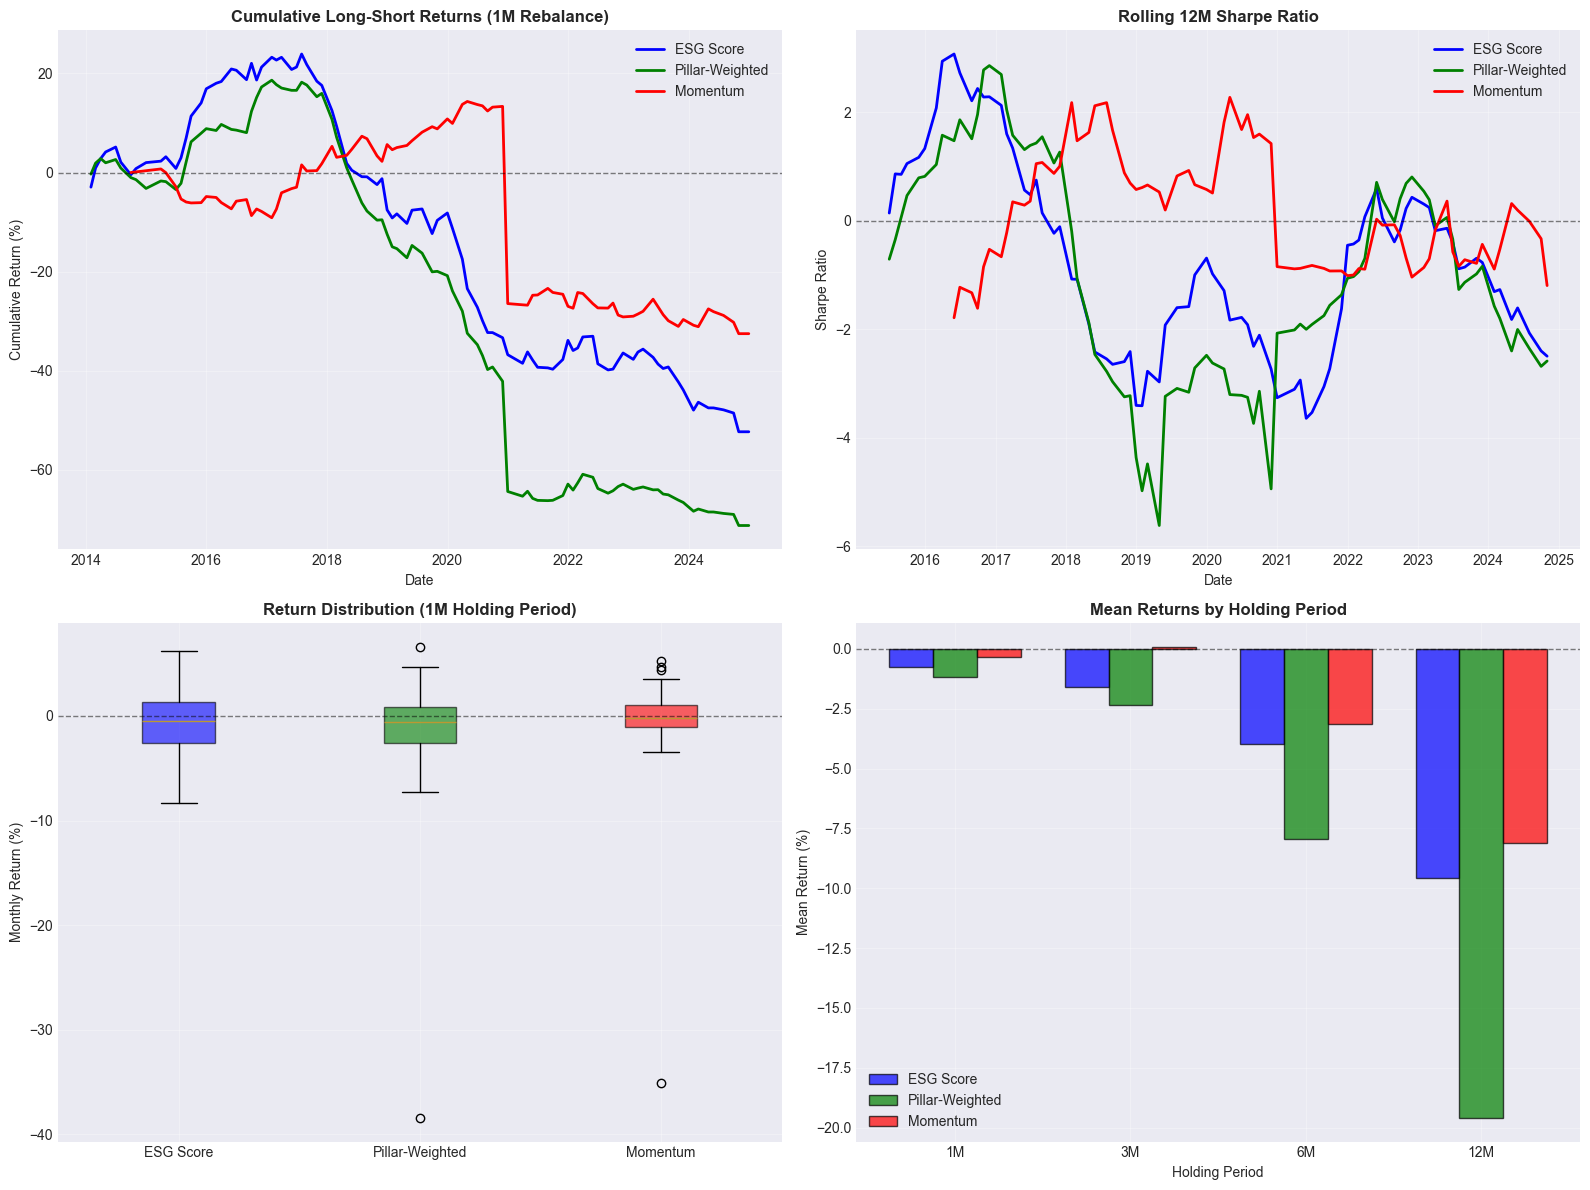

✅ Factor returns visualized


In [17]:
# Visualize factor returns
if 'price_data' in locals() and not price_data.empty and 'esg_returns' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Cumulative returns comparison (1-month holding period)
    for returns_dict, label, color in [
        (esg_returns, 'ESG Score', 'blue'),
        (pillar_returns, 'Pillar-Weighted', 'green'),
        (momentum_returns, 'Momentum', 'red')
    ]:
        if 'decile_ls_1m' in returns_dict:
            cum_ret = (1 + returns_dict['decile_ls_1m'].fillna(0)).cumprod() - 1
            axes[0, 0].plot(cum_ret.index, cum_ret.values * 100, 
                           label=label, linewidth=2, color=color)
    
    axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 0].set_title('Cumulative Long-Short Returns (1M Rebalance)', 
                         fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Cumulative Return (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Rolling Sharpe Ratio (12-month window)
    for returns_dict, label, color in [
        (esg_returns, 'ESG Score', 'blue'),
        (pillar_returns, 'Pillar-Weighted', 'green'),
        (momentum_returns, 'Momentum', 'red')
    ]:
        if 'decile_ls_1m' in returns_dict:
            rolling_sharpe = (
                returns_dict['decile_ls_1m'].rolling(12).mean() / 
                returns_dict['decile_ls_1m'].rolling(12).std()
            ) * np.sqrt(12)
            axes[0, 1].plot(rolling_sharpe.index, rolling_sharpe.values,
                           label=label, linewidth=2, color=color)
    
    axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 1].set_title('Rolling 12M Sharpe Ratio', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Sharpe Ratio')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Return distribution comparison (1-month)
    all_returns = []
    labels = []
    colors = []
    
    for returns_dict, label, color in [
        (esg_returns, 'ESG Score', 'blue'),
        (pillar_returns, 'Pillar-Weighted', 'green'),
        (momentum_returns, 'Momentum', 'red')
    ]:
        if 'decile_ls_1m' in returns_dict:
            ret = returns_dict['decile_ls_1m'].dropna() * 100
            all_returns.append(ret)
            labels.append(label)
            colors.append(color)
    
    if all_returns:
        bp = axes[1, 0].boxplot(all_returns, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[1, 0].set_title('Return Distribution (1M Holding Period)', 
                            fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('Monthly Return (%)')
        axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Holding period comparison (Mean returns by horizon)
    periods = ['1m', '3m', '6m', '12m']
    period_labels = ['1M', '3M', '6M', '12M']
    x = np.arange(len(periods))
    width = 0.25
    
    for i, (returns_dict, label, color) in enumerate([
        (esg_returns, 'ESG Score', 'blue'),
        (pillar_returns, 'Pillar-Weighted', 'green'),
        (momentum_returns, 'Momentum', 'red')
    ]):
        means = []
        for period in periods:
            key = f'decile_ls_{period}'
            if key in returns_dict:
                mean_ret = returns_dict[key].mean() * 100
                means.append(mean_ret)
            else:
                means.append(0)
        
        axes[1, 1].bar(x + i * width, means, width, label=label, 
                      color=color, alpha=0.7, edgecolor='black')
    
    axes[1, 1].set_title('Mean Returns by Holding Period', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Holding Period')
    axes[1, 1].set_ylabel('Mean Return (%)')
    axes[1, 1].set_xticks(x + width)
    axes[1, 1].set_xticklabels(period_labels)
    axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Factor returns visualized")

## 8. Calculate Factor Returns

Now we'll calculate factor returns for all three formation methods to evaluate their predictive power. We'll implement:
- **Long-Short Portfolios**: Top decile (D10) vs Bottom decile (D1)
- **Quintile Spreads**: Top 20% vs Bottom 20%
- **Equal-weighted returns** within each portfolio

This analysis requires price data to calculate forward returns.

## 8. Save Factor Data

Save all three factor datasets for further analysis or backtesting.

In [ ]:
# Save factor datasets
output_dir = Path("data/results/esg_factors")
output_dir.mkdir(parents=True, exist_ok=True)

# Save all three methods
timestamp = pd.Timestamp.now().strftime('%Y%m%d')

file_esg = output_dir / f"notebook_esg_score_{timestamp}.parquet"
file_pillar = output_dir / f"notebook_pillar_weighted_{timestamp}.parquet"
file_momentum = output_dir / f"notebook_momentum_{timestamp}.parquet"

factors_esg_score.to_parquet(file_esg, index=False)
factors_pillar_weighted.to_parquet(file_pillar, index=False)
factors_momentum.to_parquet(file_momentum, index=False)

print("=" * 80)
print("✅ ESG FACTORS SAVED")
print("=" * 80)
print(f"\n📁 Output directory: {output_dir}")
print(f"\n📄 Files created:")
print(f"   1. {file_esg.name}")
print(f"      Size: {file_esg.stat().st_size / 1024 / 1024:.2f} MB")
print(f"      Shape: {factors_esg_score.shape}")
print(f"\n   2. {file_pillar.name}")
print(f"      Size: {file_pillar.stat().st_size / 1024 / 1024:.2f} MB")
print(f"      Shape: {factors_pillar_weighted.shape}")
print(f"\n   3. {file_momentum.name}")
print(f"      Size: {file_momentum.stat().st_size / 1024 / 1024:.2f} MB")
print(f"      Shape: {factors_momentum.shape}")

print(f"\n💡 To load factors later:")
print(f"   factors = pd.read_parquet('{file_esg}')")

## 9. Factor Summary Statistics

In [ ]:
# Generate comprehensive summary statistics
print("=" * 80)
print("📊 COMPREHENSIVE FACTOR SUMMARY")
print("=" * 80)

# Summary for each method
methods = [
    ('ESG Score Formation', factors_esg_score, 'esg_score'),
    ('Pillar-Weighted Formation', factors_pillar_weighted, 'pillar_weighted_score'),
    ('Momentum Formation', factors_momentum, 'esg_score_momentum_12m')
]

for method_name, df, score_col in methods:
    print(f"\n{'=' * 80}")
    print(f"{method_name}")
    print(f"{'=' * 80}")
    
    print(f"\n📈 Overall Statistics:")
    print(f"   Total observations: {len(df):,}")
    print(f"   Unique tickers: {df['ticker'].nunique()}")
    print(f"   Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
    print(f"   Time periods: {df['date'].nunique()}")
    
    if score_col in df.columns:
        score_stats = df[score_col].describe()
        print(f"\n📊 {score_col} Statistics:")
        print(f"   Mean: {score_stats['mean']:.2f}")
        print(f"   Std Dev: {score_stats['std']:.2f}")
        print(f"   Min: {score_stats['min']:.2f}")
        print(f"   25%: {score_stats['25%']:.2f}")
        print(f"   Median: {score_stats['50%']:.2f}")
        print(f"   75%: {score_stats['75%']:.2f}")
        print(f"   Max: {score_stats['max']:.2f}")
        print(f"   Coverage: {df[score_col].notna().sum() / len(df) * 100:.1f}%")
    
    # Factor columns
    factor_cols = [col for col in df.columns if any(x in col for x in ['_zscore', '_pctrank', '_decile'])]
    if factor_cols:
        print(f"\n🎯 Factor Columns ({len(factor_cols)}):")
        for col in factor_cols:
            coverage = df[col].notna().sum() / len(df) * 100
            print(f"   - {col}: {coverage:.1f}% coverage")

print(f"\n{'=' * 80}")
print("✅ SUMMARY COMPLETE")
print(f"{'=' * 80}")

# Summary: ESG Factor Construction with ESGFactorBuilder

## Key Accomplishments

This notebook demonstrated the complete ESG factor construction workflow using the **ESGFactorBuilder** class:

### 1. **Three Formation Methods Implemented**

- ✅ **ESG Score Formation**: Cross-sectional rankings based on composite ESG scores
- ✅ **Pillar-Weighted Formation**: Custom-weighted combinations of E, S, G pillars  
- ✅ **Momentum Formation**: Time-series ESG improvement signals (6-month, 12-month)

### 2. **Cross-Sectional Factors Created**

For each formation method, the following factors were generated:
- **Z-scores**: Standardized scores (mean=0, std=1) for each time period
- **Percentile Ranks**: 0-100 rankings within each cross-section
- **Deciles**: Portfolio assignment buckets (1=lowest, 10=highest)

### 3. **Data Quality Validated**

- ✅ Score distributions examined across time
- ✅ Factor stability verified through time-series analysis
- ✅ Cross-sectional properties confirmed (uniform deciles, normal z-scores)
- ✅ Pillar correlations analyzed for independence

### 4. **Visualization Suite**

- 📊 Time-series evolution of ESG scores and coverage
- 📊 Cross-sectional distributions and rankings
- 📊 Momentum dynamics (improvers vs decliners)
- 📊 Method comparisons and correlations
- 📊 Pillar contribution analysis

## Next Steps

### For Portfolio Construction:
1. Use **decile assignments** for long-short portfolios (D10 vs D1)
2. Combine with price data to calculate factor returns
3. Test factor timing strategies using momentum signals

### For Multi-Factor Models:
1. Integrate ESG factors with traditional factors (value, momentum, quality)
2. Test orthogonality and incremental alpha contribution
3. Build composite scores combining multiple dimensions

### For Risk Management:
1. Monitor factor exposures across portfolios
2. Analyze sector-specific ESG effects
3. Track ESG improvement trends for risk mitigation

## File Outputs

All three factor datasets saved to: `data/results/esg_factors/`
- `notebook_esg_score_YYYYMMDD.parquet`
- `notebook_pillar_weighted_YYYYMMDD.parquet`
- `notebook_momentum_YYYYMMDD.parquet`

---

**ESGFactorBuilder** provides a production-ready framework for systematic ESG factor research and portfolio construction. 🚀